I have had two simple raspberry pi weather stations running for a while now.

Both have pressure, temperature and humidity sensors.

One I have in the *carefully controlled environment* of my study, the
other is hanging out of the window.

The study one is known as *pijessie* as it started life as a Raspberry
Pi running the Jessie version of Raspbian.

The outside station is known as *kittycam* as I intend at some point
to attach a camera so I can watch our cat come and go.

For a while I have been noticing that the pressure values have been
quite a way apart.  The software I am includes a conversion to
altitude and I find these numbers more natural for me to think about.

The altitude conversion assumes the pressure at sea level is 1023.25
hPa, which is the mean pressure at sea level.

When the pressure is higher than this the altitude comes out below sea
level, when pressure is lower than this above sea level.

As always, Wikipedia has good information on this:
https://en.wikipedia.org/wiki/Atmospheric_pressure

For a while I had been noticing the two sensors giving values
differing by about 10 metres altitude.

I had put this down to the sensors not being calibrated accurately,
but also noticed that kittycam was more prone to weird glitches.

Now the glitches I put down to the fact I have one process collecting
data every minute and another process creating a display on my laptop
so I can glance over and see what the weather is doing.  The latter
was just polling the sensor every 10 minutes.

The code does not do anything smart like get a lock and my guess was
that the two processes were occasionally trampling on each other's feet.

Long story short, I decided to take a closer look.

In [34]:
# Tell matplotlib to plot in line
%matplotlib inline

import datetime

# import pandas
import pandas

# seaborn magically adds a layer of goodness on top of Matplotlib
# mostly this is just changing matplotlib defaults, but it does also
# provide some higher level plotting methods.
import seaborn

# Tell seaborn to set things up
seaborn.set()


In [35]:
# input files: the data from the two sensors
infiles = ["../files/kittycam_weather.csv", "../files/pijessie_weather.csv"]


In [36]:
# Read the data

data = []

for infile in infiles:
    data.append(pandas.read_csv(infile, index_col='date', parse_dates=['date']))


In [37]:
# take a look at what we got
data[0].describe()

,temp,pressure,altitude,sealevel_pressure,humidity,temp_dht
count,42768.000000,42768.000000,42768.000000,42768.000000,42764.000000,42764.000000
mean,28.114357,101385.375842,-5.068642,101387.094487,76.806599,27.730374
std,2.205370,430.276252,36.334073,409.738250,8.512122,2.068583
min,22.800000,56117.000000,-1314.018026,67136.000000,29.500000,22.299999
25%,26.500000,101141.750000,-26.939647,101142.000000,71.599998,26.200001
50%,27.700000,101411.000000,-7.157439,101412.000000,77.099998,27.400000
75%,29.900000,101648.000000,15.246750,101649.000000,83.500000,29.299999
max,43.200000,102242.000000,3397.334521,118353.000000,94.300003,47.099998


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f1a6b1e4128>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f1a6aeb2908>], dtype=object)

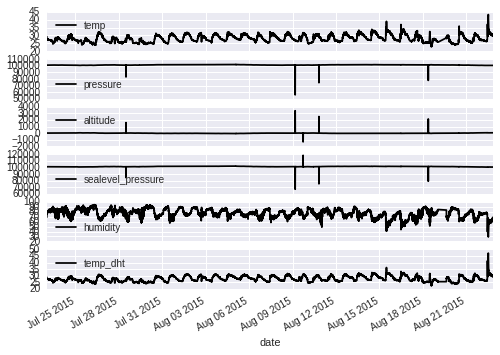

In [38]:
# plots are always good 

data[0].plot(subplots=True)

Now the two sets of data have different indices since the processes
collecting the data are not in sync.

So we need to align the data and then fill in missing values

In [39]:
# align returns two new dataframes, now aligned
d1, d2 = data[0].align(data[1])

In [40]:
# have a look, note the count is just the valid data.
# Things have been aligned, but missing values are set ton NaN
d1.describe()

,temp,pressure,altitude,sealevel_pressure,humidity,temp_dht
count,42768.000000,42768.000000,42768.000000,42768.000000,42764.000000,42764.000000
mean,28.114357,101385.375842,-5.068642,101387.094487,76.806599,27.730374
std,2.205370,430.276252,36.334073,409.738250,8.512122,2.068583
min,22.800000,56117.000000,-1314.018026,67136.000000,29.500000,22.299999
25%,26.500000,101141.750000,-26.939647,101142.000000,71.599998,26.200001
50%,27.700000,101411.000000,-7.157439,101412.000000,77.099998,27.400000
75%,29.900000,101648.000000,15.246750,101649.000000,83.500000,29.299999
max,43.200000,102242.000000,3397.334521,118353.000000,94.300003,47.099998


In [41]:
# Use interpolation to fill in the missing values
d1 = d1.interpolate(method='time')
d2 = d2.interpolate(method='time')



80476


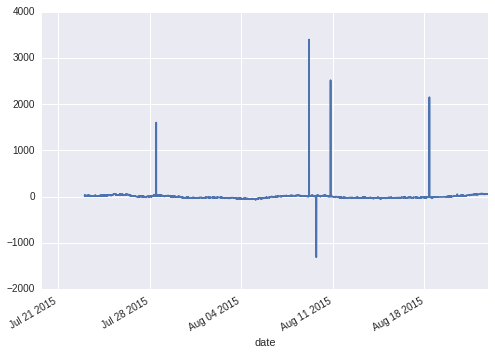

In [42]:
# Now plot
d1.altitude.plot()
print(len(d1))

In [43]:
# For convenience, add a new series to d1 with the altitude data from d2
d1['altitude2'] = d2.altitude

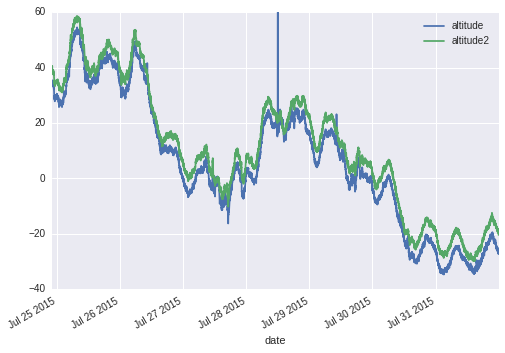

In [44]:
# Now plot the two
d1[['altitude', 'altitude2']][10000:30000].clip(-60,60).plot()

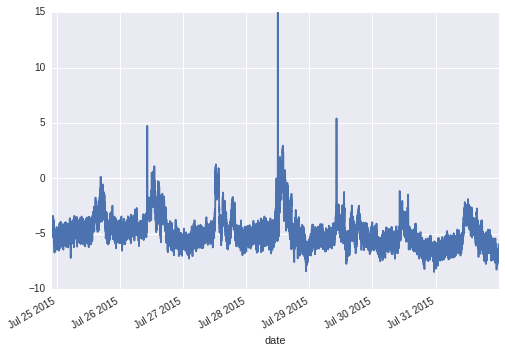

In [45]:
(d1.altitude - d1.altitude2)[10000:30000].clip(-20,15).plot()

So we do have a difference around 5m.  More interestingly, there seems to be some sort of daily pattern to the data.